In [1]:
#loading in respective imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
sns.set(style="darkgrid")

In [2]:
#reading in parameter settings and creating dict for data viz
pdSingleParamDataset = pd.read_excel("../dataInputs/inputSheet.xlsx",sheet_name='systemSettings')
pdEyParamDataset = pd.read_excel("../dataInputs/inputSheet.xlsx",sheet_name='eyUnitSettings')

parameterSettingsDict = {}

for paramName,paramValue in zip(pdSingleParamDataset["ParamName"],pdSingleParamDataset["Value"]):
    parameterSettingsDict[paramName] = paramValue

In [3]:
#reading in output from optimization model and setting up structure for data viz
singleValueData = pd.read_excel("../modelOutputs/testRun.xlsx",sheet_name="singleValueDvs").abs()

hourlySingleValueData = pd.read_excel("../modelOutputs/testRun.xlsx",sheet_name="hourlyValueDvs").abs()

hourlyEyValueData = pd.read_excel("../modelOutputs/testRun.xlsx",sheet_name="hourlyEyValueDvs",usecols="B").abs()


combinedDf = pd.concat([hourlySingleValueData,hourlyEyValueData.rename(columns={0: "eyGen"})], axis=1, join='inner')

#cleaning up combined data and adding new column for data analysis purposes
del combinedDf["Unnamed: 0"]
combinedDf["eyDirectToHb"] = combinedDf["eyGen"] - (combinedDf["hsStore"]/parameterSettingsDict["hsDeployEfficiency"])


singleValueData.head()

,Unnamed: 0,windCapacity,solarCapacity,bsCapacity,hsCapacity,asuCapacity,hbCapacity,totalSystemCost,LCOA,windCosts,...,eyCapexCosts,eyOpexCosts,hsCapexCosts,hsOpexCosts,bsCapexCosts,bsOpexCosts,asuCapexCosts,asuOpexCosts,hbCapexCosts,hbOpexCosts
0,0,257.172846,278.712784,34.55846,47228.520934,8140.517291,9891.272529,1.055486e+09,1.189194,0.499979,...,0.126751,0.030825,0.026606,0.00647,0.015575,0.003787,0.013299,0.003234,0.038341,0.009323


Text(0, 0.5, 'Power Available (MWh)')

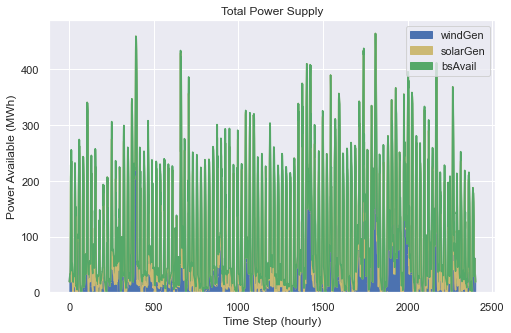

In [4]:
ax = combinedDf.plot.area(x="timestep", y=["windGen","solarGen","bsAvail"],
                style=['b','y','g'],figsize=(8, 5))
plt.title("Total Power Supply")
plt.xlabel("Time Step (hourly)")
plt.ylabel("Power Available (MWh)")

Text(0, 0.5, 'MWh')

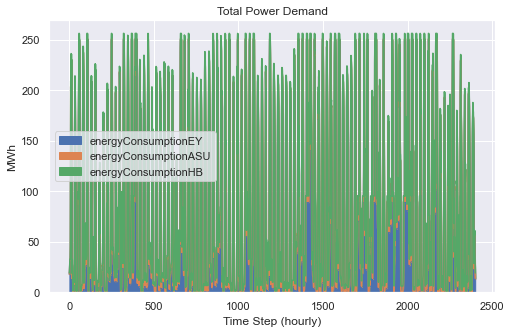

In [5]:
#now looking at energy consumption
#creating new panda columns
combinedDf["energyConsumptionEY"] = combinedDf["eyGen"]*pdEyParamDataset["energyUseEY"][0]
combinedDf["energyConsumptionASU"] = combinedDf["asuGen"]*parameterSettingsDict["energyUseASU"]
combinedDf["energyConsumptionHB"] = combinedDf["hbGen"]*parameterSettingsDict["energyUseHB"]
combinedDf["energyConsumptionBS"] = combinedDf["bsStore"]/parameterSettingsDict["bsStoreEfficiency"]
combinedDf["energyConsumptionHS"] = combinedDf["hsAvail"]*parameterSettingsDict["energyUseHS"]

combinedDf.plot.area(x="timestep", y=["energyConsumptionEY","energyConsumptionASU","energyConsumptionHB"],
                figsize=(8, 5))

plt.title("Total Power Demand")
plt.xlabel("Time Step (hourly)")
plt.ylabel("MWh")

Text(0, 0.5, 'MWh')

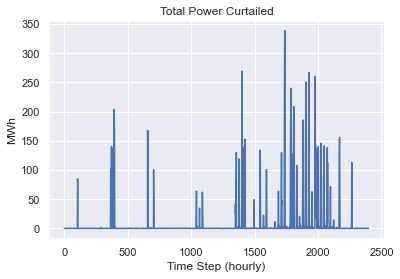

In [6]:
#looking at energy curtailed
energyCurtailedDf = combinedDf["windGen"] + combinedDf["solarGen"] + combinedDf["bsDeploy"] - combinedDf["energyConsumptionBS"] - combinedDf["energyConsumptionHS"] - combinedDf["energyConsumptionEY"]- combinedDf["energyConsumptionASU"] - combinedDf["energyConsumptionHB"]

energyCurtailedDf.plot()
plt.title("Total Power Curtailed")
plt.xlabel("Time Step (hourly)")
plt.ylabel("MWh")

Text(0, 0.5, 'Power (MWh)')

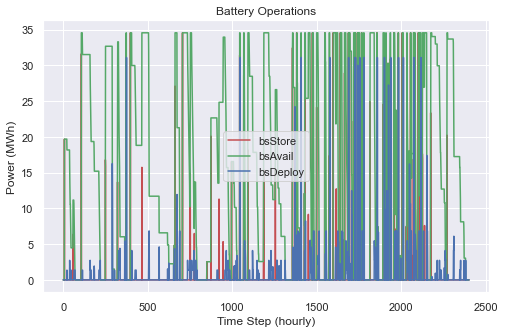

In [7]:
combinedDf.plot(x="timestep", y=["bsStore","bsAvail","bsDeploy"],
                style=['r','g','b'],figsize=(8, 5))
plt.title("Battery Operations")
plt.xlabel("Time Step (hourly)")
plt.ylabel("Power (MWh)")

Text(0, 0.5, 'Hydrogen (kg)')

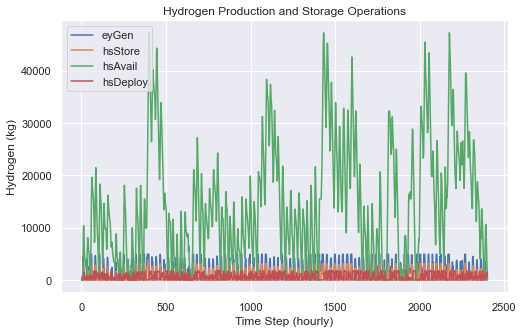

In [8]:
combinedDf.plot(x="timestep", y=["eyGen","hsStore","hsAvail","hsDeploy"],
                figsize=(8, 5))
plt.title("Hydrogen Production and Storage Operations")
plt.xlabel("Time Step (hourly)")
plt.ylabel("Hydrogen (kg)")

Text(0, 0.5, 'Chemical Production(kg)')

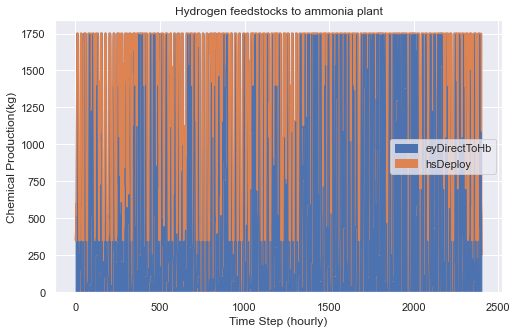

In [9]:
combinedDf.plot.area(x="timestep", y=["eyDirectToHb","hsDeploy"],
                figsize=(8, 5))
#generation ,"asuGen","hbGen"
plt.title("Hydrogen feedstocks to ammonia plant")
plt.xlabel("Time Step (hourly)")
plt.ylabel("Chemical Production(kg)")

Text(0, 0.5, '$/kg')

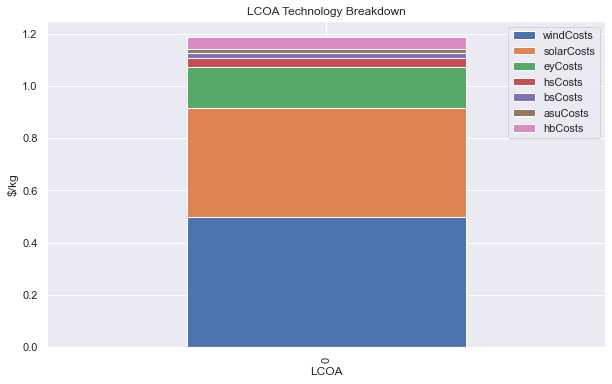

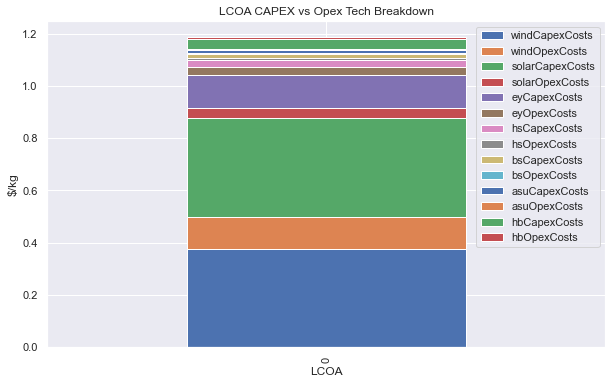

In [10]:
#now looking at LCOA costs breakdown
costDataColNames = ["windCosts","solarCosts","eyCosts","hsCosts",
                                        "bsCosts","asuCosts","hbCosts"]
dfTechCosts = singleValueData[costDataColNames]
dfTechCosts.plot.bar(stacked=True,figsize=(10, 6))
plt.title("LCOA Technology Breakdown")
plt.xlabel("LCOA")
plt.ylabel("$/kg")

'''
#checking to make sure the two cost calculations add up
for techName in ["wind","solar","ey","hs","bs","asu","hb"]:
    singleCostString = f"{techName}Costs"
    detailedCostString1 = f"{techName}CapexCosts"
    detailedCostString2 = f"{techName}OpexCosts"
    print(f"single costs {singleValueData[singleCostString][0]} = {singleValueData[detailedCostString1][0] + singleValueData[detailedCostString2][0]}")

'''

newCostDataColNames = ["windCapexCosts","windOpexCosts","solarCapexCosts","solarOpexCosts",
                                        "eyCapexCosts","eyOpexCosts","hsCapexCosts","hsOpexCosts",
                                        "bsCapexCosts", "bsOpexCosts","asuCapexCosts","asuOpexCosts",
                                        "hbCapexCosts","hbOpexCosts"]
dfHighDefCosts = singleValueData[newCostDataColNames]
dfHighDefCosts.plot.bar(stacked=True,figsize=(10, 6))
plt.title("LCOA CAPEX vs Opex Tech Breakdown")
plt.xlabel("LCOA")
plt.ylabel("$/kg")